In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.Session(config=config)

In [3]:
import keras.backend as K
import keras.layers as layers
from keras.models import Model
from keras.utils import to_categorical

#K.set_floatx('float64')

Using TensorFlow backend.


In [4]:
import numpy as np
import matplotlib.pyplot as plt

In [5]:
import time

In [6]:
import util

In [7]:
sig, bg = util.load_data(nevt=400000)

In [8]:
print(bg.shape)
print(sig.shape)

(181783, 700, 3)
(36434, 700, 3)


In [9]:
# cluster jets, requiring pT>1.6 TeV

cluster_args = dict(ntrk = 128,
                    R = 1.0,
                    min_ntrk = 1,
                    min_jet_pt = 1600,
                    min_trk_pt = 0.5)

bg_jets, bg_consts = util.cluster_jets(bg, **cluster_args)
sig_jets, sig_consts = util.cluster_jets(sig, **cluster_args)
print(bg_consts.shape)
print(sig_consts.shape)

(26876, 128, 3)
(21950, 128, 3)


Text(0.5, 0, '# of constituents')

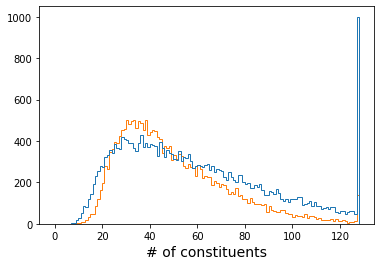

In [10]:
bg_ntrk = np.sum(bg_consts[:,:,0]>0, axis=-1)
sig_ntrk = np.sum(sig_consts[:,:,0]>0, axis=-1)
plt.hist([bg_ntrk, sig_ntrk], histtype='step', bins=128, range=(0,128));
plt.xlabel("# of constituents")

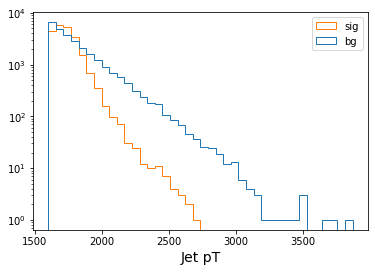

In [11]:
plt.hist([bg_jets[:,0], sig_jets[:,0]], histtype='step', bins=40, label=['bg','sig'])
plt.yscale('log')
plt.xlabel("Jet pT")
plt.legend();

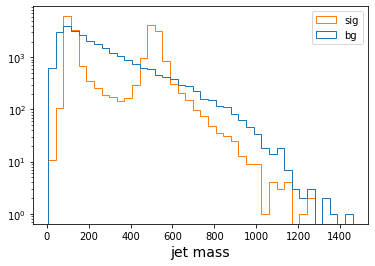

In [12]:
plt.hist([bg_jets[:,3], sig_jets[:,3]], histtype='step', bins=40, label=['bg', 'sig'])
plt.yscale('log');
plt.xlabel("jet mass")
plt.legend();

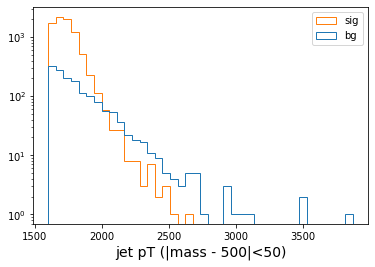

In [13]:
plt.hist([bg_jets[:,0][np.abs(bg_jets[:,3]-500)<50], sig_jets[:,0][np.abs(sig_jets[:,3]-500)<50]], histtype='step', bins=40, label=['bg','sig'])
plt.yscale('log');
plt.xlabel("jet pT (|mass - 500|<50)")
plt.legend();

In [14]:
# Format the dataset for input to the NN.
# First stack to together data from the two classes

nsig = len(sig_consts)
nbg = len(bg_consts)
ncls = min(nsig, nbg)

X = np.concatenate([bg_consts[:ncls], sig_consts[:ncls]], axis=0).copy()

# convert pT units to TeV (to limit range of inputs to NN)
X[:,:,0] /= 1000.

# make labels for bg (=0) and signal(=1)
y = np.zeros(X.shape[0], dtype=int)
y[ncls:] = 1

# randomly assign 85% of data to training sample, reserve the rest for validation
is_train = np.random.rand(X.shape[0])<0.85

X_train = X[is_train]
y_train = y[is_train]

X_val = X[~is_train]
y_val = y[~is_train]


# also make flipped labels for adversarial training
y_train_flipped = (y_train+1)%2
y_val_flipped = (y_val+1)%2

In [15]:
print("ncls =",ncls)
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)

ncls = 21950
(37417, 128, 3)
(37417,)
(6483, 128, 3)
(6483,)


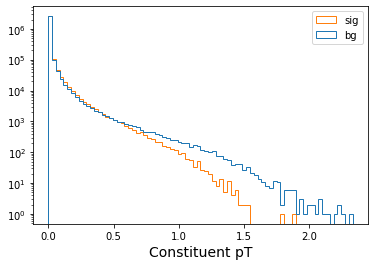

In [16]:
plt.hist([X[y==0][:,:,0].flatten(), X[y==1][:,:,0].flatten()],histtype='step',bins=80, label=['bg','sig']);
plt.yscale('log')
plt.xlabel('Constituent pT')
plt.legend();

## Test out ECF calculation

In [17]:
util.ecf_numpy(2, -1, sig_consts[:10,:32])

array([1.50970653e+08, 5.35899070e+07, 3.24825552e+07, 5.51665038e+07,
       5.61867678e+08, 1.28993196e+08, 6.17007814e+07, 9.21314479e+07,
       1.44751400e+08, 7.78917410e+07])

In [18]:
sig_consts.shape

(21950, 128, 3)

16 constituents: 0.08sec/1000evts
32 constituents: 0.46sec/1000evts
64 constituents: 3.29sec/1000evts


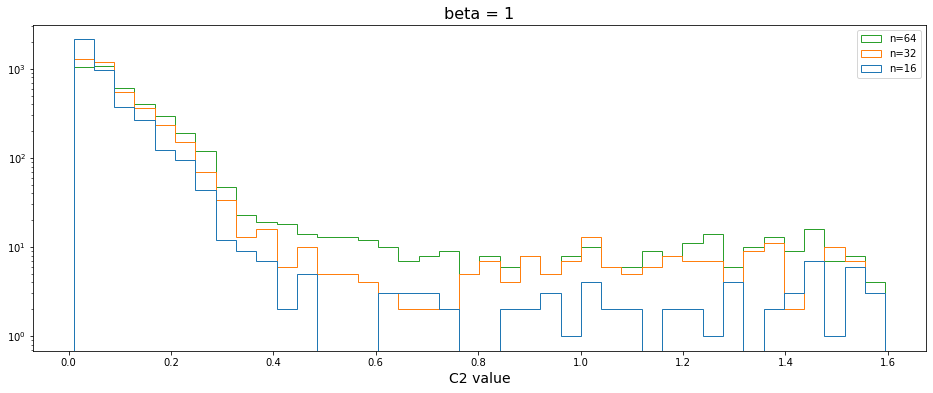

In [19]:
beta = 1

# batch out the computation to avoid huge memory allocation
batch_size = 64
n_batch = min(64, sig_consts.shape[0]//batch_size)

# make a comparison of C2 for different number of input constituents
nmax_scan = [16,32,64]
c2_scan = []
for nmax in nmax_scan:
    t0 = time.time()
    c2 = np.zeros(batch_size*n_batch)
    for ibatch in range(n_batch):
        e1 = util.ecf_numpy(1, beta, sig_consts[ibatch*batch_size:(ibatch+1)*batch_size,:nmax])
        e2 = util.ecf_numpy(2, beta, sig_consts[ibatch*batch_size:(ibatch+1)*batch_size,:nmax])
        e3 = util.ecf_numpy(3, beta, sig_consts[ibatch*batch_size:(ibatch+1)*batch_size,:nmax])
        c2[ibatch*batch_size:(ibatch+1)*batch_size] = e3*e1/(e2**2)
    dt = time.time()-t0
    print("%d constituents: %.2fsec/1000evts" % (nmax,dt/c2.shape[0]*1000))
    c2_scan.append(c2)

plt.figure(figsize=(16,6))
plt.hist(c2_scan, histtype='step', bins=40, label=['n=%d'%n for n in nmax_scan])
plt.legend()
plt.yscale('log');
plt.xlabel("C2 value");
plt.title("beta = %g"%beta, fontsize=16);

16 constituents: 0.07sec/1000evts
32 constituents: 0.45sec/1000evts
64 constituents: 3.27sec/1000evts


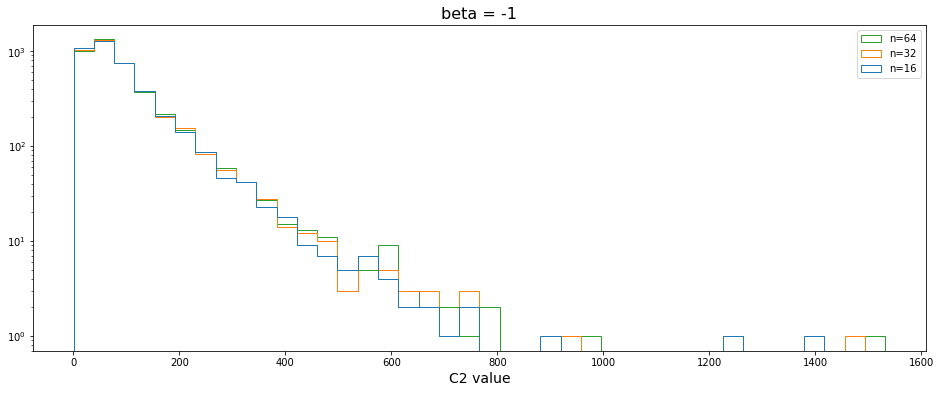

In [20]:
beta = -1

# batch out the computation to avoid huge memory allocation
batch_size = 64
n_batch = min(64, sig_consts.shape[0]//batch_size)

# make a comparison of C2 for different number of input constituents
nmax_scan = [16,32,64]
c2_scan = []
for nmax in nmax_scan:
    t0 = time.time()
    c2 = np.zeros(batch_size*n_batch)
    for ibatch in range(n_batch):
        e1 = util.ecf_numpy(1, beta, sig_consts[ibatch*batch_size:(ibatch+1)*batch_size,:nmax])
        e2 = util.ecf_numpy(2, beta, sig_consts[ibatch*batch_size:(ibatch+1)*batch_size,:nmax])
        e3 = util.ecf_numpy(3, beta, sig_consts[ibatch*batch_size:(ibatch+1)*batch_size,:nmax])
        c2[ibatch*batch_size:(ibatch+1)*batch_size] = e3*e1/(e2**2)
    dt = time.time()-t0
    print("%d constituents: %.2fsec/1000evts" % (nmax,dt/c2.shape[0]*1000))
    c2_scan.append(c2)

plt.figure(figsize=(16,6))
plt.hist(c2_scan, histtype='step', bins=40, label=['n=%d'%n for n in nmax_scan])
plt.legend()
plt.yscale('log');
plt.xlabel("C2 value");
plt.title("beta = %g"%beta, fontsize=16);

In [21]:
beta = -1
nmax = 32

e1_bg = util.ecf_numpy(1,beta,bg_consts[:,:nmax], normalized=True)
e2_bg = util.ecf_numpy(2,beta,bg_consts[:,:nmax], normalized=True)
e3_bg = util.ecf_numpy(3,beta,bg_consts[:,:nmax], normalized=True)
c2_bg = e3_bg / (e2_bg**2)
d2_bg = e3_bg / (e2_bg**3)

e1_sig = util.ecf_numpy(1,beta,sig_consts[:,:nmax], normalized=True)
e2_sig = util.ecf_numpy(2,beta,sig_consts[:,:nmax], normalized=True)
e3_sig = util.ecf_numpy(3,beta,sig_consts[:,:nmax], normalized=True)
c2_sig = e3_sig*e1_sig/(e2_sig**2)
d2_sig = e3_sig*(e1_sig**3)/(e2_sig**3)

In [22]:
# Do a quick check that both normalized and un-normalized give the same results

e1_bg_nonorm = util.ecf_numpy(1,beta,bg_consts[:,:nmax], normalized=False)
e2_bg_nonorm = util.ecf_numpy(2,beta,bg_consts[:,:nmax], normalized=False)
e3_bg_nonorm = util.ecf_numpy(3,beta,bg_consts[:,:nmax], normalized=False)
c2_bg_nonorm = e3_bg_nonorm*e1_bg_nonorm/(e2_bg_nonorm**2)
d2_bg_nonorm = e3_bg_nonorm*(e1_bg_nonorm**3)/(e2_bg_nonorm**3)

print("Max rel error in C2:", np.max(np.abs((c2_bg-c2_bg_nonorm)/c2_bg)))
print("Max rel error in D2:", np.max(np.abs((d2_bg-d2_bg_nonorm)/d2_bg)))

Max rel error in C2: 6.461968390614324e-16
Max rel error in D2: 8.931081909555754e-16


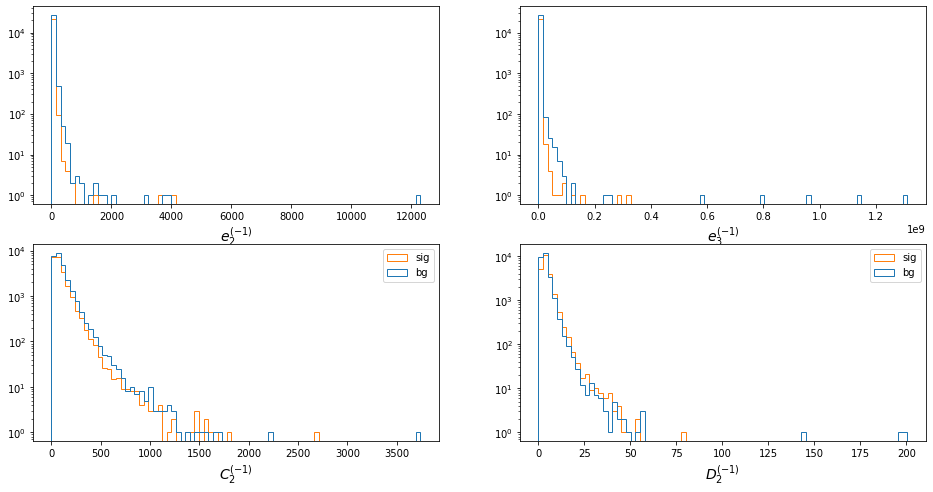

In [23]:
plt.figure(figsize=(16,8))
plt.subplot(2,2,1)
plt.hist([e2_bg, e2_sig], histtype='step', bins=80);
plt.yscale('log');
plt.xlabel(r"$e_2^{(%g)}$"%beta)
plt.subplot(2,2,2)
plt.hist([e3_bg, e3_sig], histtype='step', bins=80);
plt.yscale('log')
plt.xlabel(r"$e_3^{(%g)}$"%beta)
plt.subplot(2,2,3)
plt.hist([c2_bg, c2_sig], histtype='step', bins=80, label=['bg','sig']);
plt.yscale('log')
plt.xlabel(r"$C_2^{(%g)}$"%beta);
plt.legend();
plt.subplot(2,2,4)
plt.hist([d2_bg, d2_sig], histtype='step', bins=80, label=['bg','sig']);
plt.yscale('log')
plt.xlabel(r"$D_2^{(%g)}$"%beta);
plt.legend();

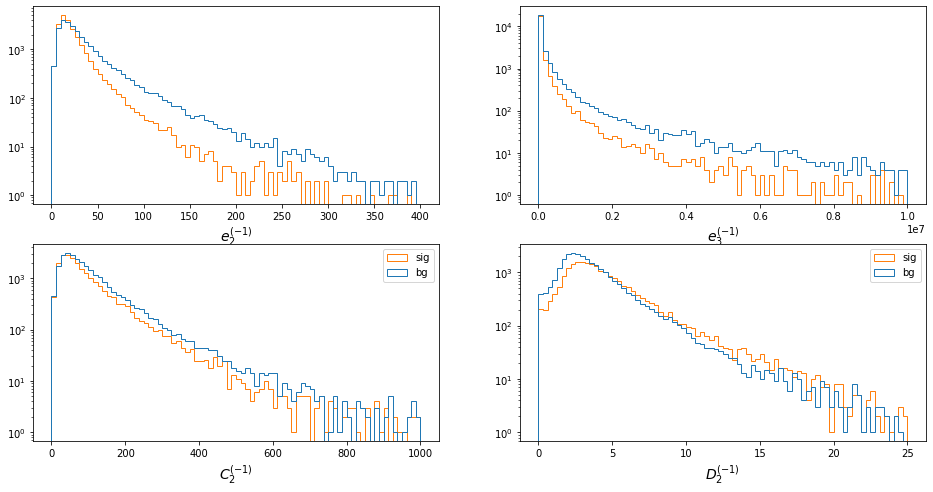

In [24]:
plt.figure(figsize=(16,8))
plt.subplot(2,2,1)
plt.hist([e2_bg, e2_sig], histtype='step', bins=80, range=(0,400));
plt.yscale('log');
plt.xlabel(r"$e_2^{(%g)}$"%beta)
plt.subplot(2,2,2)
plt.hist([e3_bg, e3_sig], histtype='step', bins=80, range=(0,1e7));
plt.yscale('log')
plt.xlabel(r"$e_3^{(%g)}$"%beta)
plt.subplot(2,2,3)
plt.hist([c2_bg, c2_sig], histtype='step', bins=80, range=(0,1e3), label=['bg','sig']);
plt.yscale('log')
plt.xlabel(r"$C_2^{(%g)}$"%beta);
plt.legend();
plt.subplot(2,2,4)
plt.hist([d2_bg, d2_sig], histtype='step', bins=80, range=(0,25), label=['bg','sig']);
plt.yscale('log')
plt.xlabel(r"$D_2^{(%g)}$"%beta);
plt.legend();

## Test tensorflow ECF implementation

In [25]:
def mk_test_model(ntrk, beta=-1):    
    model_input = layers.Input((ntrk,3))
    
    f_ecf1 = lambda x: util.ecf_tf(1, beta, x, normalized=False)
    f_ecf2 = lambda x: util.ecf_tf(2, beta, x, normalized=False)
    f_ecf3 = lambda x: util.ecf_tf(3, beta, x, normalized=False)
    
    def f_c2(x):
        ecf1, ecf2, ecf3 = x
        return ecf3 * ecf1 / tf.square(ecf2)
    def f_d2(x):
        ecf1, ecf2, ecf3 = x
        return ecf3 * tf.pow(ecf1, 3) / tf.pow(ecf2, 3)
    
    ecf1 = layers.Lambda(f_ecf1)(model_input)
    ecf2 = layers.Lambda(f_ecf2)(model_input)
    ecf3 = layers.Lambda(f_ecf3)(model_input)
    
    c2 = layers.Lambda(f_c2)([ecf1, ecf2, ecf3])
    d2 = layers.Lambda(f_d2)([ecf1, ecf2, ecf3])
    
    model_output = layers.Concatenate()([ecf1,ecf2,ecf3,c2,d2])
    
    model = Model(model_input, model_output)
    return model

In [26]:
K.clear_session()

nscan = [16,32,64,128]
models = {}
for n in nscan:
    print("Building model with n=%d"%n)
    models[n] = mk_test_model(n)

Building model with n=16
Building model with n=32
Building model with n=64
Building model with n=128


In [27]:
gpu_sig = models[nmax].predict(sig_consts[:,:nmax])
gpu_bg = models[nmax].predict(bg_consts[:,:nmax])
sig_err_c2 = c2_sig-gpu_sig[:,3]
sig_err_d2 = d2_sig-gpu_sig[:,4]


print("Max rel. error (signal):")
print("C2:",np.max(np.abs(sig_err_c2/c2_sig)))
print("D2:",np.max(np.abs(sig_err_d2/d2_sig)))

bg_err_c2 = c2_bg-gpu_bg[:,3]
bg_err_d2 = d2_bg-gpu_bg[:,4]

print("Max rel. error (background):")
print("C2:",np.max(np.abs(bg_err_c2/c2_bg)))
print("D2:",np.max(np.abs(bg_err_d2/d2_bg)))

Max rel. error (signal):
C2: 1.027020889767892e-06
D2: 1.4521037073195553e-06
Max rel. error (background):
C2: 1.1064635530710571e-06
D2: 1.6099619291426627e-06


In [28]:
results_sig = {}
results_bg = {}
for n in nscan:
    print("Calculating for n=%d" % n)
    tstart = time.time()
    results_sig[n] = models[n].predict(sig_consts[:,:n])
    results_bg[n] = models[n].predict(bg_consts[:,:n])
    dt = time.time()-tstart
    print("  done in %.1fs (%.2fs/1000evt)" % (dt, dt/(len(sig_consts)+len(bg_consts))*1000))

Calculating for n=16
  done in 3.4s (0.07s/1000evt)
Calculating for n=32
  done in 4.8s (0.10s/1000evt)
Calculating for n=64
  done in 11.4s (0.23s/1000evt)
Calculating for n=128
  done in 28.6s (0.59s/1000evt)


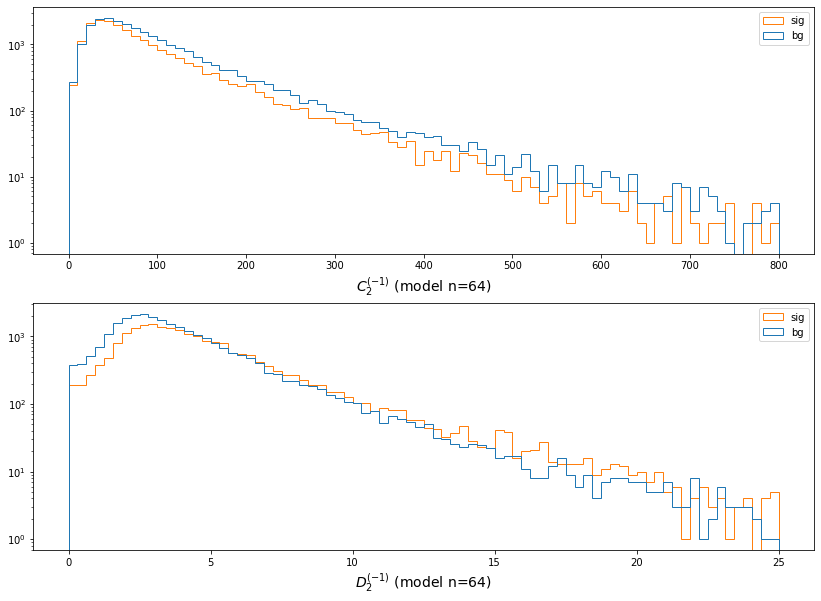

In [29]:
nplot = 64

plt.figure(figsize=(14,10))
plt.subplot(211)
plt.hist([results_bg[nplot][:,3], results_sig[nplot][:,3]], histtype='step', bins=80, range=(0,800), label=['bg','sig']);
plt.yscale('log');
plt.xlabel(r"$C_2^{(%g)}$ (model n=%d)"%(beta,nplot));
plt.legend()
plt.subplot(212)
plt.hist([results_bg[nplot][:,4], results_sig[nplot][:,4]], histtype='step', bins=80, range=(0,25), label=['bg','sig']);
plt.yscale('log');
plt.xlabel(r"$D_2^{(%g)}$ (model n=%d)"%(beta,nplot));
plt.legend();

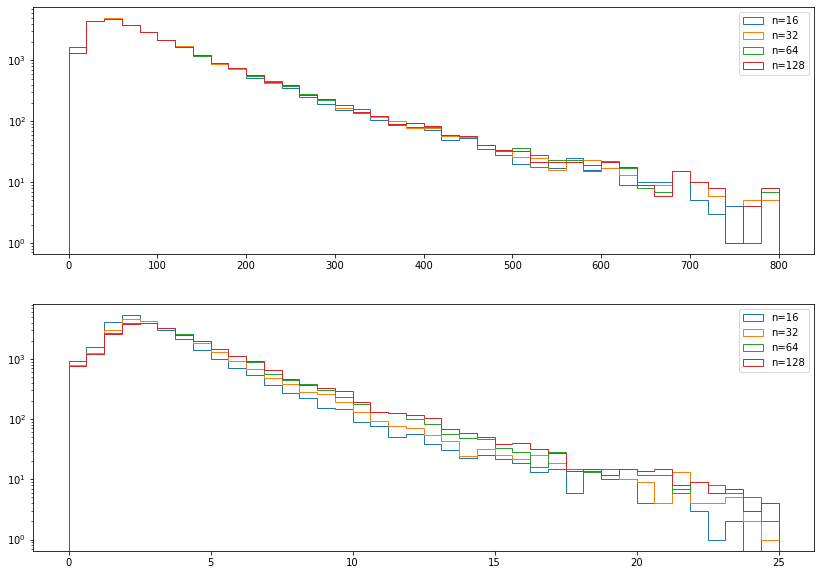

In [30]:
plt.figure(figsize=(14,10))
plt.subplot(211)
for n in nscan:
    plt.hist(results_bg[n][:,3], histtype='step', bins=40, range=(0,800), label='n=%d'%n)
plt.yscale('log')
plt.legend()
plt.subplot(212)
for n in nscan:
    plt.hist(results_bg[n][:,4], histtype='step', bins=40, range=(0,25), label='n=%d'%n)
plt.yscale('log')
plt.legend();

## Build classifier / adversary networks

In [16]:
# build and return three keras NN models: (classifier, adv, composed)
# The classifier takes `ntrk` constituents from a leading jet, and outputs [0,1]
# The adversary takes `ntrk` constituents, and outputs the same shape with the 4-vectors perturbed
# The composed model is the result of the classifier applied to adversary outputs, i.e. output=adv(cls(input))

def mk_model(ntrk, dropout=0.25):
    K.clear_session()
    
    classifier_input = layers.Input((ntrk,3))
    
    H = classifier_input
    
    H = layers.Flatten()(H)
    
    for _ in range(2):
        H = layers.Dense(128, activation='relu')(H)
        if dropout:
            H = layers.Dropout(dropout)(H)
    
    H = layers.Dense(2, activation='softmax')(H)
    
    classifier = Model(classifier_input, H)
    
    classifier.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
    
    adv_input = layers.Input((ntrk,3))
    H = adv_input
    
    
    pt = layers.Lambda(lambda x: x[:,:,0:1])(H)
    eta = layers.Lambda(lambda x: x[:,:,1:2])(H)
    phi = layers.Lambda(lambda x: x[:,:,2:3])(H)
    
    
    pt_reg_weight = K.variable(1.0)
    def pt_reg(pt_weights):
        return pt_reg_weight*K.sum(K.square(pt_weights))
    
    eta_reg_weight = K.variable(1.0)
    def eta_reg(eta_weights):
        return eta_reg_weight*K.sum(K.square(eta_weights))
    
    phi_reg_weight = K.variable(1.0)
    def phi_reg(phi_weights):
        return phi_reg_weight*K.sum(K.square(phi_weights))
    
    H = layers.Flatten()(H)
    
    H = layers.Dense(256, activation='relu')(H)
    H = layers.Dense(256, activation='relu')(H)
    
    delta_pt = layers.Dense(ntrk, activation=None, activity_regularizer=pt_reg)(H)
    delta_pt = layers.Reshape((-1,1))(delta_pt)
    
    delta_eta = layers.Dense(ntrk, activation=None, activity_regularizer=eta_reg)(H)
    delta_eta = layers.Reshape((-1,1))(delta_eta)
    
    delta_phi = layers.Dense(ntrk, activation=None, activity_regularizer=phi_reg)(H)
    delta_phi = layers.Reshape((-1,1))(delta_phi)
    
    
    pt_new = layers.Lambda(lambda x: x[0]+x[1])([pt, delta_pt])
    pt_new = layers.ReLU()(pt_new)
    
    eta_new = layers.Lambda(lambda x: x[0]+x[1])([eta, delta_eta])
    
    phi_new = layers.Lambda(lambda x: x[0]+x[1])([phi, delta_phi])
    
    adv_output = layers.Concatenate()([pt_new,eta_new,phi_new])
    
    adv = Model(adv_input, adv_output)
    
    comp_input = layers.Input((ntrk,3))
    comp_output = classifier(adv(comp_input))
    comp = Model(comp_input, comp_output)
    
    comp.pt_reg_weight = pt_reg_weight
    comp.eta_reg_weight = eta_reg_weight
    comp.phi_reg_weight = phi_reg_weight
    
    classifier.trainable = False
    comp.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
    classifier.trainable = True
    
    return classifier, adv, comp

In [17]:
classifier, adv, comp = mk_model(ntrk)

classifier.summary()
adv.summary()

# NB you need to set the classifier weights to be untrainable when using the composed model.
classifier.trainable=False
comp.summary()
classifier.trainable=True

classifier_losses = []
classifier_val_losses = []
classifier_acc = []
classifier_val_acc = []

adv_losses = []
adv_val_losses = []
adv_acc = []
adv_val_acc = []

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 32, 3)             0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 96)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               12416     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               16512     
_________________________________________________________________
dropout_2 (Dropout)  

In [18]:
save_weights = False
load_weights = True

if save_weights:
    print("saving weights")
    classifier.save_weights('classifier_weights.h5')
if load_weights:
    print("loading weights")
    classifier.load_weights('classifier_weights.h5')

loading weights


## Train a simple signal/bg classifier

In [579]:
# train the signal classifier first
epochs = 16
batch_size = 128 #64

lr = 4e-4

K.set_value(classifier.optimizer.lr, lr)

try:
    classifier.fit(X_train, to_categorical(y_train,2),
              validation_data=(X_val, to_categorical(y_val,2)),
              batch_size=batch_size, epochs=epochs)
except KeyboardInterrupt:
    pass

classifier_losses.extend(classifier.history.history['loss'])
classifier_val_losses.extend(classifier.history.history['val_loss'])
classifier_acc.extend(classifier.history.history['acc'])
classifier_val_acc.extend(classifier.history.history['val_acc'])

Train on 78321 samples, validate on 13685 samples
Epoch 1/16
26752/78321 [=========>....................] - ETA: 2s - loss: 0.5184 - acc: 0.7389

KeyError: 'loss'

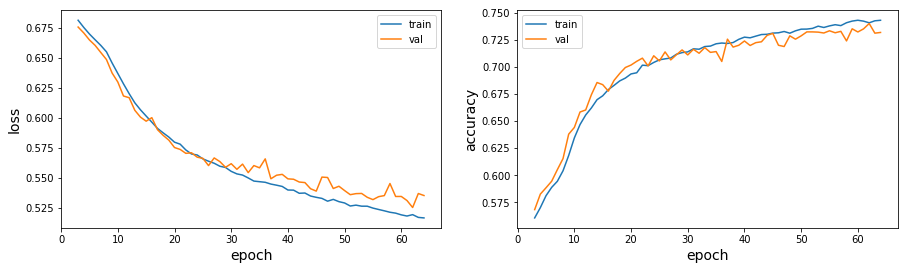

In [51]:
xstart = 2

xepochs = np.arange(len(classifier_losses))+1

plt.figure(figsize=(15,4))
plt.subplot(121)
plt.plot(xepochs[xstart:], classifier_losses[xstart:], label='train')
plt.plot(xepochs[xstart:], classifier_val_losses[xstart:], label='val')
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend();

plt.subplot(122)
plt.plot(xepochs[xstart:], classifier_acc[xstart:], label='train')
plt.plot(xepochs[xstart:], classifier_val_acc[xstart:], label='val')
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.legend();

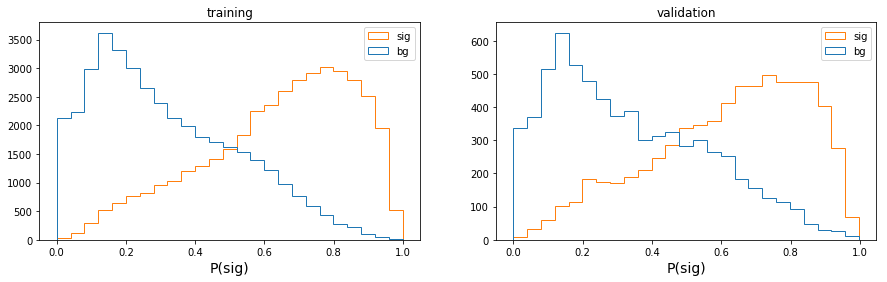

In [59]:
plt.figure(figsize=(15,4))

hargs = dict(histtype='step', bins=25, label=['bg','sig'])

plt.subplot(121)
plt.hist([classifier.predict(X_train[y_train==0])[:,1], classifier.predict(X_train[y_train==1])[:,1]], **hargs)
plt.xlabel("P(sig)")
plt.title("training")
plt.legend();

plt.subplot(122)
plt.hist([classifier.predict(X_val[y_val==0])[:,1], classifier.predict(X_val[y_val==1])[:,1]], **hargs)
plt.xlabel("P(sig)")
plt.title("validation")
plt.legend();

In [60]:
classifier.evaluate(X_val, to_categorical(y_val,2))

13685/13685 [==============================] - 1s 61us/step


[0.5349997447361944, 0.731896236794771]

In [61]:
classifier.evaluate(X_val[y_val==0], to_categorical(y_val[y_val==0],2))

6861/6861 [==============================] - 0s 64us/step


[0.49492090435734193, 0.7481416703365128]

In [62]:
classifier.evaluate(X_val[y_val==1], to_categorical(y_val[y_val==1],2))

6824/6824 [==============================] - 0s 59us/step


[0.57529589670065, 0.7155627198124267]

In [63]:
np.sum(y_val)/len(y_val)

0.49864815491413955

## train an adversary to modify jet constituents to fool classifier

In [727]:
# Once the classifier is trained to a satisfactory level, we can freeze its weights
# and train to adversary, by training the composed model to maximize the opposite classification.
epochs = 4
batch_size = 128

lr = 1e-4

pt_reg_weight = 3e-2
phi_reg_weight = 3e-2
eta_reg_weight = 3e-2


K.set_value(comp.optimizer.lr, lr)
K.set_value(comp.pt_reg_weight, pt_reg_weight)

mode = 'flip' # one of ('flip', 'bg', 'signal'); the target output label for perturbed jets

if mode == 'flip':
    # completely switch labels
    y_train_target = y_train_flipped
    y_val_target = y_val_flipped
elif mode == 'bg':
    # train to output BG jets
    y_train_target = np.zeros_like(y_train)
    y_val_target = np.zeros_like(y_val)
elif mode == 'signal':
    # train to output BG jets
    y_train_target = np.ones_like(y_train)
    y_val_target = np.ones_like(y_val)
else:
    raise ValueError("Bad training mode")

classifier.trainable = False
try:
    comp.fit(X_train, to_categorical(y_train_target, 2),
             validation_data=(X_val, to_categorical(y_val_target, 2)),
             batch_size=batch_size, epochs=epochs, verbose=2)
except KeyboardInterrupt:
    pass

classifier.trainable = True

adv_losses.extend(comp.history.history['loss'])
adv_val_losses.extend(comp.history.history['val_loss'])

adv_acc.extend(comp.history.history['acc'])
adv_val_acc.extend(comp.history.history['val_acc'])

Train on 78321 samples, validate on 13685 samples
Epoch 1/4
 - 4s - loss: 1.1830 - acc: 0.3075 - val_loss: 1.0577 - val_acc: 0.3518
Epoch 2/4
 - 5s - loss: 1.1226 - acc: 0.3543 - val_loss: 1.0545 - val_acc: 0.3663
Epoch 3/4
 - 4s - loss: 1.1163 - acc: 0.3567 - val_loss: 1.0430 - val_acc: 0.3649
Epoch 4/4
 - 4s - loss: 1.1110 - acc: 0.3567 - val_loss: 1.0424 - val_acc: 0.3659


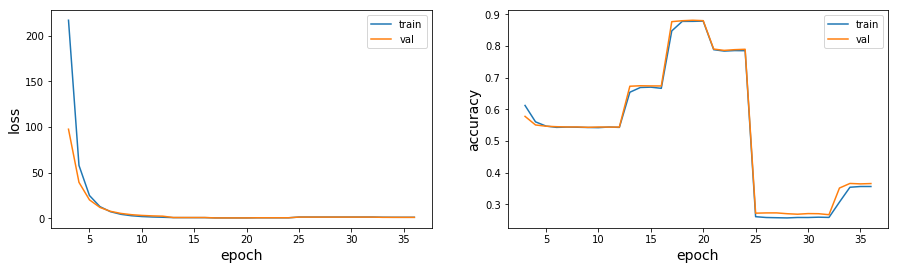

In [728]:
xstart = 2

xepochs = np.arange(len(adv_losses))+1

plt.figure(figsize=(15,4))
plt.subplot(121)
plt.plot(xepochs[xstart:], adv_losses[xstart:], label='train')
plt.plot(xepochs[xstart:], adv_val_losses[xstart:], label='val')
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend();

plt.subplot(122)
plt.plot(xepochs[xstart:], adv_acc[xstart:], label='train')
plt.plot(xepochs[xstart:], adv_val_acc[xstart:], label='val')
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.legend();

In [729]:
classifier.evaluate(X_val, to_categorical(y_val, 2))

13685/13685 [==============================] - 1s 63us/step


[0.5349997447361944, 0.731896236794771]

In [730]:
classifier.evaluate(adv.predict(X_val), to_categorical(y_val, 2))

13685/13685 [==============================] - 1s 56us/step


[0.6407223412447878, 0.6340518816614134]

In [731]:
classifier.evaluate(adv.predict(X_val[y_val==0]), to_categorical(y_val[y_val==0], 2))

6861/6861 [==============================] - 0s 54us/step


[0.6526186610168209, 0.6299373269637113]

In [732]:
classifier.evaluate(adv.predict(X_val[y_val==1]), to_categorical(y_val[y_val==1], 2))

6824/6824 [==============================] - 0s 49us/step


[0.6287615165061995, 0.6381887456037515]

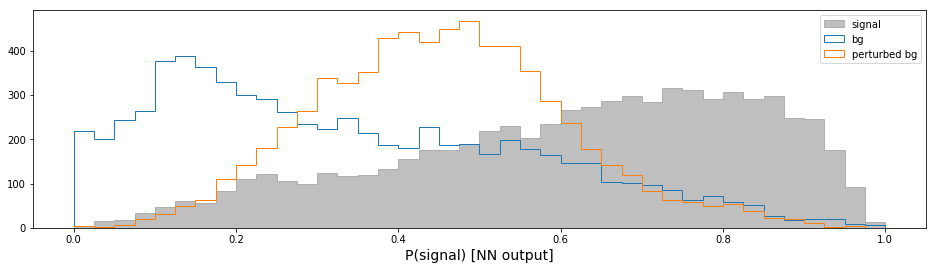

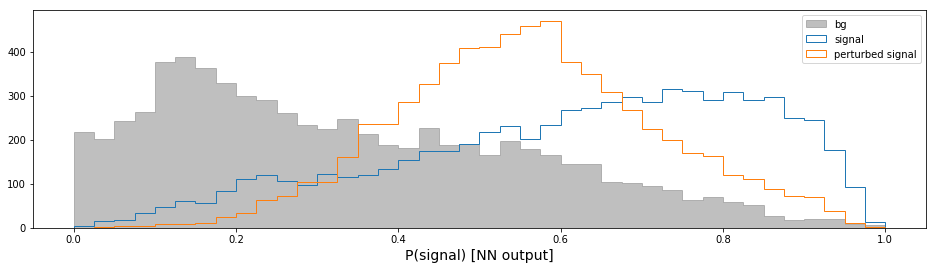

In [733]:
hargs = dict(histtype='step', bins=40, range=(0,1))

plt.figure(figsize=(16,4))
plt.hist(classifier.predict(X_val[y_val==1])[:,1], color='gray', fill=True, alpha=0.5, label='signal', **hargs);
plt.hist(classifier.predict(X_val[y_val==0])[:,1], label='bg', **hargs);
plt.hist(classifier.predict(adv.predict(X_val[y_val==0]))[:,1], label='perturbed bg', **hargs)
plt.xlabel("P(signal) [NN output]")
plt.legend();

plt.figure(figsize=(16,4))
plt.hist(classifier.predict(X_val[y_val==0])[:,1], color='gray', fill=True, alpha=0.5, label='bg', **hargs);
plt.hist(classifier.predict(X_val[y_val==1])[:,1], label='signal', **hargs);
plt.hist(classifier.predict(adv.predict(X_val[y_val==1]))[:,1], label='perturbed signal', **hargs)
plt.xlabel("P(signal) [NN output]")
plt.legend();

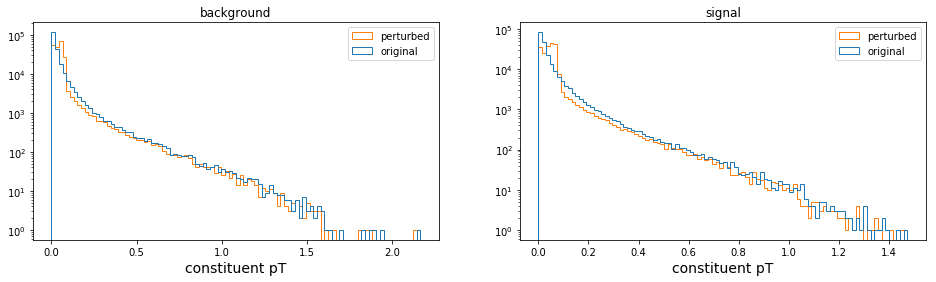

In [737]:
# plot the pT of the constituents before/after being perturbed by the adversary
plt.figure(figsize=(16,4))
plt.subplot(121)
plt.hist([X_val[y_val==0][:,:,0].flatten(), adv.predict(X_val[y_val==0])[:,:,0].flatten()],
         bins=100, histtype='step', label=['original','perturbed']);
plt.yscale('log')
plt.xlabel("constituent pT")
plt.title("background")
plt.legend();

plt.subplot(122)
plt.hist([X_val[y_val==1][:,:,0].flatten(), adv.predict(X_val[y_val==1])[:,:,0].flatten()],
         bins=100, histtype='step', label=['original','perturbed']);
plt.yscale('log')
plt.xlabel("constituent pT")
plt.title("signal")
plt.legend();

In [738]:
jets_before = cluster_jets(X_val, ntrk=ntrk, pt_min=0, gev=True, ntrk_min=0)[0]
jets_after = cluster_jets(adv.predict(X_val), ntrk=ntrk, pt_min=0, gev=True, ntrk_min=0)[0]
assert jets_before.shape == jets_after.shape

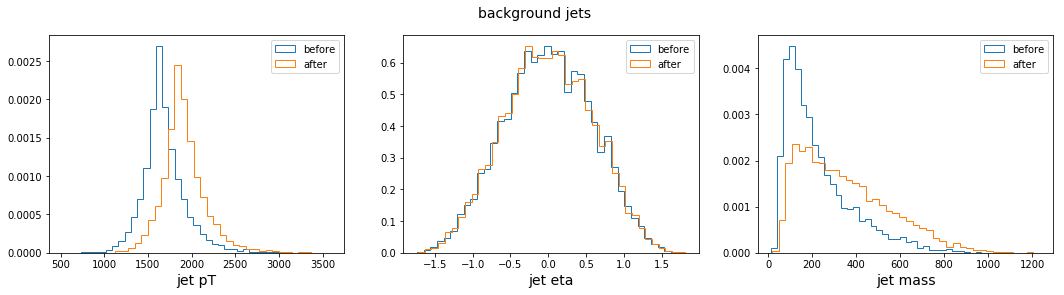

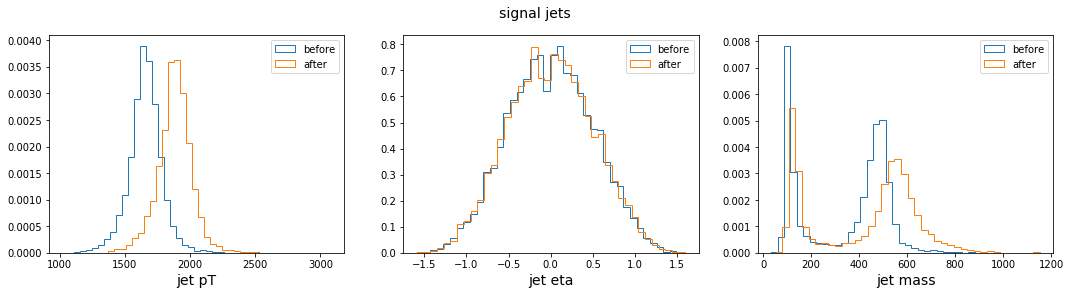

In [739]:
hargs = dict(histtype='step', bins=40, density=True)

plt.figure(figsize=(18,4))
plt.subplot(131)
plt.hist(jets_before[y_val==0][:,0], label='before', **hargs)
plt.hist(jets_after[y_val==0][:,0], label='after', **hargs)
plt.xlabel("jet pT")
plt.legend()
plt.subplot(132)
plt.hist(jets_before[y_val==0][:,1], label='before', **hargs)
plt.hist(jets_after[y_val==0][:,1], label='after', **hargs)
plt.xlabel("jet eta")
plt.legend()
plt.subplot(133)
plt.hist(jets_before[y_val==0][:,3], label='before', **hargs)
plt.hist(jets_after[y_val==0][:,3], label='after', **hargs)
plt.xlabel("jet mass")
plt.legend();
plt.suptitle("background jets", fontsize=14);

plt.figure(figsize=(18,4))
plt.subplot(131)
plt.hist(jets_before[y_val==1][:,0], label='before', **hargs)
plt.hist(jets_after[y_val==1][:,0], label='after', **hargs)
plt.xlabel("jet pT")
plt.legend()
plt.subplot(132)
plt.hist(jets_before[y_val==1][:,1], label='before', **hargs)
plt.hist(jets_after[y_val==1][:,1], label='after', **hargs)
plt.xlabel("jet eta")
plt.legend()
plt.subplot(133)
plt.hist(jets_before[y_val==1][:,3], label='before', **hargs)
plt.hist(jets_after[y_val==1][:,3], label='after', **hargs)
plt.xlabel("jet mass")
plt.legend();
plt.suptitle("signal jets", fontsize=14);

## per-event adversarial examples using FGSM

In [508]:
# pick a particular jet, and initialize the adversarial example with its values. also initialize the adversarial noise with zeros

njet = 6000
target_class = 0

use_sign = False

target_name = ['bg', 'signal'][target_class]
other_name = ['signal','bg'][target_class]

x = X_val[y_val==target_class][:njet]
x_adv = x.copy()
x_noise = np.zeros_like(x)

prediction_history     = [classifier.predict(x)[:,target_class].mean()]
prediction_history_quant = [np.quantile(classifier.predict(x)[:,target_class],[0.5,0.68,0.95])]

In [509]:
# Define the epsilons in the (pt, eta, phi) directions
epsilons = (5e-5,5e-4,5e-4)
nstep = 4

# Then loop for the desired number of iterations to update the adversarial
# noise using the classifier loss gradient:

sess = K.get_session()
epsilon = K.reshape(K.constant(epsilons), (1,1,3))
for istep in range(nstep):
    print("FGSM %d/%d..."%(istep+1,nstep))
    loss = -1*K.categorical_crossentropy(to_categorical((target_class+1)%2,2), classifier.get_output_at(0))
    grads = K.gradients(loss, classifier.get_input_at(0))
    
    if use_sign:
        delta = K.sign(grads[0])
    else:
        delta = grads[0]
    x_noise = x_noise + delta
    
    x_adv = x_adv + epsilon*delta
    x_adv = sess.run(x_adv, feed_dict={classifier.get_input_at(0):x})
    preds = classifier.predict(x_adv)[:,target_class]
    prediction_history.append(preds.mean())
    prediction_history_quant.append(np.quantile(preds, [0.5,0.68,0.9]))
    print("  avg:", preds.mean())

FGSM 1/4...
  avg: 0.60597974
FGSM 2/4...
  avg: 0.5397721
FGSM 3/4...
  avg: 0.474871
FGSM 4/4...
  avg: 0.41850182


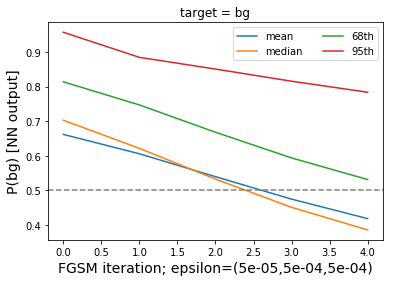

In [510]:
plt.plot(prediction_history, label='mean')
plt.plot(np.array(prediction_history_quant)[:,0], label='median')
plt.plot(np.array(prediction_history_quant)[:,1], label='68th')
plt.plot(np.array(prediction_history_quant)[:,2], label='95th')
plt.xlabel("FGSM iteration; epsilon=(%.e,%.e,%.e)"%epsilons)
plt.ylabel("P(%s) [NN output]"%target_name)
plt.title("target = %s"%target_name)
plt.axhline(0.5, ls='--', color='gray')
plt.legend(ncol=2);

In [511]:
classifier.evaluate(x_adv, to_categorical([target_class]*len(x_adv),2))

6000/6000 [==============================] - 0s 65us/step


[1.1043573563893636, 0.3546666666666667]

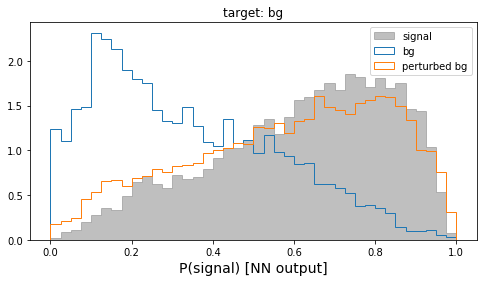

In [512]:
hargs = dict(histtype='step', bins=40, range=(0,1), density=True)

plt.figure(figsize=(8,4))
plt.hist(classifier.predict(X_val[y_val!=target_class])[:,1], color='gray', fill='gray', alpha=0.5, label=other_name, **hargs)
plt.hist(classifier.predict(x)[:,1], label='%s'%target_name, **hargs)
plt.hist(classifier.predict(x_adv)[:,1], label='perturbed %s'%target_name, **hargs)
plt.xlabel("P(signal) [NN output]")
plt.title("target: %s" % target_name)
#plt.ylim(top=plt.ylim()[1]*1.2)
plt.legend();

In [513]:
# re-cluster the constituents to see if there's any effect on the jet-level kinematics:

jet_before = cluster_jets(x, ntrk=ntrk, pt_min=0, gev=True, ntrk_min=0)[0]
jet_after = cluster_jets(x_adv, ntrk=ntrk, pt_min=0, gev=True, ntrk_min=0)[0]

assert jet_before.shape == jet_after.shape

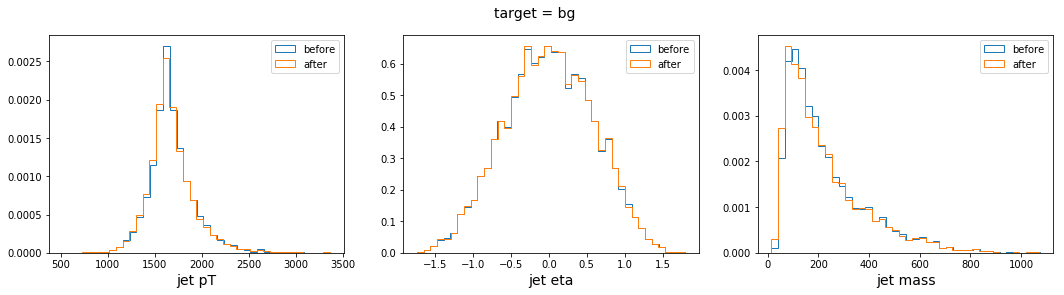

In [514]:
hargs = dict(histtype='step', bins=40, density=True)

plt.figure(figsize=(18,4))
plt.subplot(131)
plt.hist(jet_before[:,0], label='before', **hargs)
plt.hist(jet_after[:,0], label='after', **hargs)
plt.xlabel("jet pT")
plt.legend()
plt.subplot(132)
plt.hist(jet_before[:,1], label='before', **hargs)
plt.hist(jet_after[:,1], label='after', **hargs)
plt.xlabel("jet eta")
plt.legend()
plt.subplot(133)
plt.hist(jet_before[:,3], label='before', **hargs)
plt.hist(jet_after[:,3], label='after', **hargs)
plt.xlabel("jet mass")
plt.legend();
plt.suptitle("target = %s" % target_name, fontsize=14);

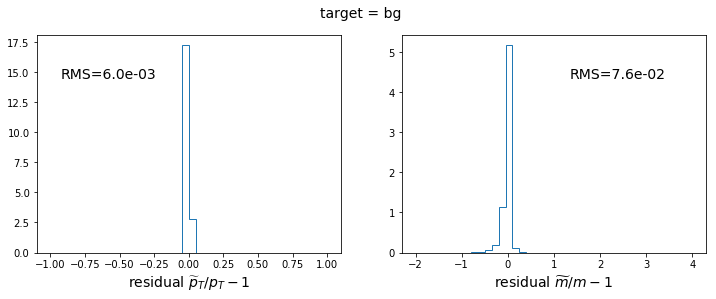

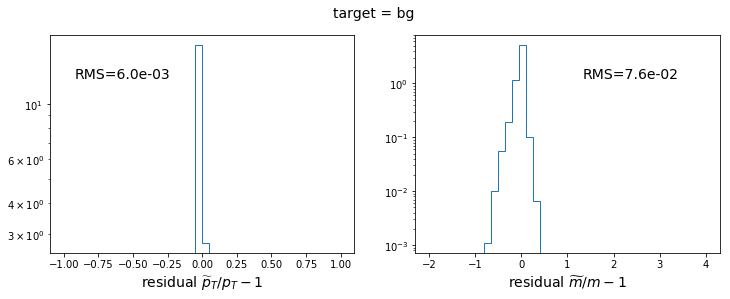

In [515]:
hargs = dict(histtype='step', bins=40, color='C0', density=True)

plt.figure(figsize=(12,4))

pt_pull = jet_after[:,0]/jet_before[:,0]-1
mass_pull = jet_after[:,3]/jet_before[:,3]-1

plt.subplot(121)
plt.hist(jet_after[:,0]/jet_before[:,0]-1, range=(-1,1), **hargs);
plt.xlabel(r"residual $\widetilde{p}_T/ p_T- 1$")
plt.text(0.08, 0.8, 'RMS=%.1e'%pt_pull.std(), fontsize=14, transform=plt.gca().transAxes)
plt.subplot(122)
plt.hist(jet_after[:,3]/jet_before[:,3]-1, range=(-2,4), **hargs);
plt.xlabel(r"residual $\widetilde{m} / m - 1$")
plt.text(0.55, 0.8, 'RMS=%.1e'%mass_pull.std(), fontsize=14, transform=plt.gca().transAxes);

plt.suptitle("target = %s"%target_name, fontsize=14)

plt.figure(figsize=(12,4))

plt.subplot(121)
plt.hist(jet_after[:,0]/jet_before[:,0]-1, range=(-1,1), **hargs);
plt.xlabel(r"residual $\widetilde{p}_T/ p_T- 1$")
plt.text(0.08, 0.8, 'RMS=%.1e'%pt_pull.std(), fontsize=14, transform=plt.gca().transAxes)
plt.yscale('log')
plt.subplot(122)
plt.hist(jet_after[:,3]/jet_before[:,3]-1, range=(-2,4), **hargs);
plt.xlabel(r"residual $\widetilde{m} / m - 1$")
plt.text(0.55, 0.8, 'RMS=%.1e'%mass_pull.std(), fontsize=14, transform=plt.gca().transAxes);
plt.yscale('log');
plt.suptitle("target = %s"%target_name, fontsize=14);

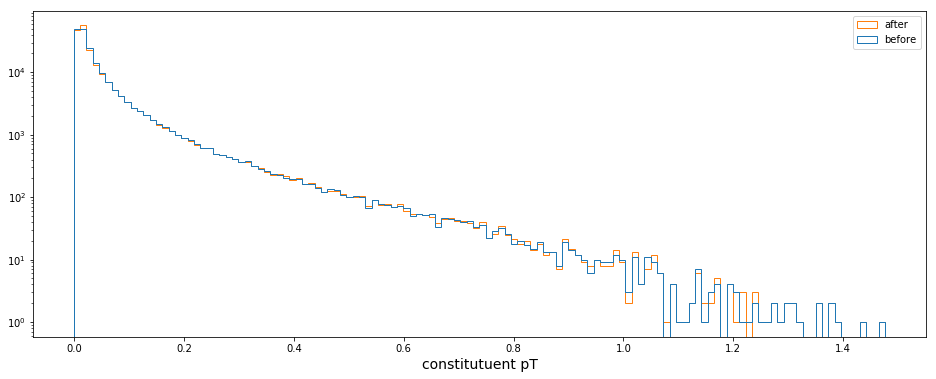

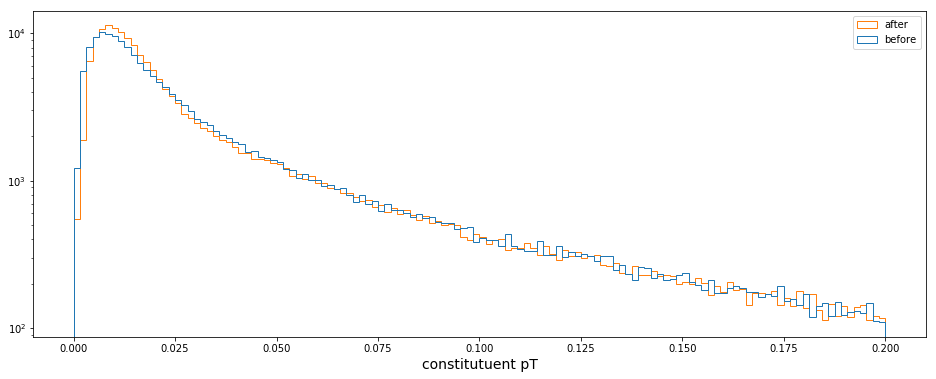

In [476]:
# plot the pT of the jet constituents before / after the adversarial perturbation
plt.figure(figsize=(16,6))
plt.hist([x[:,:,0].flatten(), x_adv[:,:,0].flatten()], histtype='step', bins=128, label=['before','after']);
plt.xlabel("constitutuent pT")
plt.yscale('log')
plt.legend();

plt.figure(figsize=(16,6))
plt.hist([x[:,:,0].flatten(), x_adv[:,:,0].flatten()], histtype='step', bins=128, range=(0,0.2), label=['before','after']);
plt.xlabel("constitutuent pT")
plt.yscale('log')
plt.legend();